In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc
from scipy import stats
import copy
import pickle
seed=314159
device='cuda'
from GPerturb import *

# Load data from Yao et al 2024

In [3]:
adata = sc.read_h5ad('yao_et_al_preprocessed.h5ad')
# GSM6858450_KD_guide_pooled.h5ad from Yao et al 2024
adata.obs['n_feature'] = (adata.X > 0).sum(1)


conds = [_.split('--') for _ in list(adata.obs.Guides_collapsed_by_gene)]
all_conds = []
for _ in conds:
    all_conds += _
all_conds = list(set(all_conds))
all_conds_lookup = {_: __ for __, _ in enumerate(all_conds)}


# duplicated perturbations are ignored, resulting in binary vectors of length 600
my_conditioner = torch.zeros((adata.X.shape[0], len(all_conds)))
for _ in range(my_conditioner.shape[0]):
    for __ in conds[_]:
        my_conditioner[_, all_conds_lookup[__]] = 1


my_observation = torch.tensor(adata.X.todense(), dtype=torch.float)

my_cell_info = adata.obs[['Total_RNA_count', 'Percent_mitochondrial_reads', 'Total_unique_genes']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 2] = my_cell_info[:, 2] / my_cell_info[:, 0]
my_cell_info[:, 0] = np.log(my_cell_info[:, 0])

# Specify and train Gaussian GPerturb

In [4]:
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000  
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]

lr_parametric = 1e-3  
tau = torch.tensor(1.0).to(device)

parametric_model = GPerturb_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                               data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                               hidden_layer_2=hidden_layer, tau=tau)
parametric_model.test_id = testing_idx = list(np.random.choice(a=range(my_observation.shape[0]), size=my_observation.shape[0] // 8, replace=False))
parametric_model = parametric_model.to(device)

# train from scratch
# parametric_model.GPerturb_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
#                                 lr=lr_parametric, device=device)

# load from pre-computed
parametric_model.load_state_dict(torch.load('yaoetal_Gaussian_ref.pt'))
parametric_model=parametric_model.to('cpu')

# Comparing with GEARS

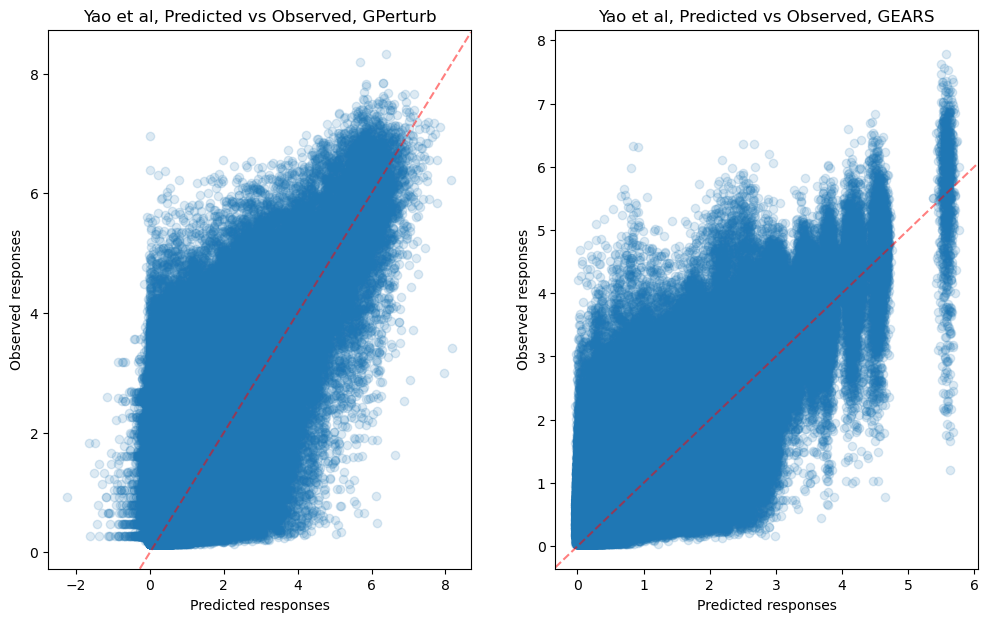

In [13]:
# # compute prediction on test set
# unique_pert = test_conditioner
# avg_pred = np.zeros((len(unique_pert), adata.X.shape[1]))
# avg_obs = np.zeros((len(unique_pert), adata.X.shape[1]))
# for i, pert in enumerate(list(unique_pert)):
#     if i%10 == 0:
#         print(i)
#     my_id = [i]
#     predicted_mu_mean, predicted_mu_var, predicted_gamma_mean, predicted_gamma_var, \
#         logit_p, logit_p_log_var, predicted_base_mean = parametric_model(test_conditioner[my_id],
#                                                                          test_cell_info[my_id])
#     estimated_base_mean = predicted_base_mean.detach().cpu().numpy()  # * zeros[testing_idx].numpy()
#     estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean).detach().cpu().numpy()
#     avg_pred[i] = (estimated_perturbed_mean + estimated_base_mean).mean(0)
#     avg_obs[i] = test_observation[my_id].mean(0).cpu().numpy()

# load from pretrained

fig, axes = plt.subplots(1, 2)
obs_mean = np.load('./GPerturb_vis_data/yao_GEARS_avg_1.npy').ravel()
pert_response = pd.read_csv('./GPerturb_vis_data/yao_GEARS_pred_1.csv', index_col=0).to_numpy().ravel()
pert_response = pert_response[obs_mean != 0]
obs_mean = obs_mean[obs_mean != 0]
axes[1].scatter(pert_response.ravel()[obs_mean.ravel() != 0], obs_mean.ravel()[obs_mean.ravel() != 0], alpha=0.15)
axes[1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1].set_xlabel('Predicted responses')
axes[1].set_ylabel('Observed responses')
axes[1].set_title('Yao et al, Predicted vs Observed, GEARS')

avg_pred = np.loadtxt('./GPerturb_vis_data/yao_pred_GPerturb.csv').ravel()
avg_obs = np.loadtxt('./GPerturb_vis_data/yao_obs_GPerturb.csv').ravel()
avg_pred = avg_pred[avg_obs != 0]
avg_obs = avg_obs[avg_obs != 0]
axes[0].scatter(avg_pred,  avg_obs, alpha=0.15)
axes[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0].set_xlabel('Predicted responses')
axes[0].set_ylabel('Observed responses')
axes[0].set_title('Yao et al, Predicted vs Observed, GPerturb')
fig.set_size_inches(12, 7)
plt.savefig('yao_GEARS_vs_GPerturb.png')

# Specify and train ZIP/ZIGP GPerturb

In [10]:
adata = sc.read_h5ad('yao_et_al_preprocessed.h5ad')
adata.obs['n_feature'] = (adata.X > 0).sum(1)

conds = [_.split('--') for _ in list(adata.obs.Guides_collapsed_by_gene)]
all_conds = []
for _ in conds:
    all_conds += _
all_conds = list(set(all_conds))
all_conds_lookup = {_: __ for __, _ in enumerate(all_conds)}


# duplicated perturbations are ignored, resulting in binary vectors of length 600
my_conditioner = torch.zeros((adata.X.shape[0], len(all_conds)))
for _ in range(my_conditioner.shape[0]):
    for __ in conds[_]:
        my_conditioner[_, all_conds_lookup[__]] = 1


my_observation = torch.tensor(adata.raw.X.todense(), dtype=torch.float)

my_cell_info = adata.obs[['Total_RNA_count', 'Percent_mitochondrial_reads', 'Total_unique_genes']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 2] = my_cell_info[:, 2] / my_cell_info[:, 0]
my_cell_info[:, 0] = np.log(my_cell_info[:, 0])


start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]

lr_parametric = 5e-4  # 7e-4 works, 2e-3 kinda works
nu_1, nu_2, nu_3, nu_4 = torch.tensor(5.).to(device), torch.tensor(0.1).to(device), torch.tensor(1.).to(device), torch.tensor(0.1).to(device)
tau = torch.tensor(1.).to(device)

parametric_model = GPerturb_ZIP(conditioner_dim=conditioner_dim, output_dim=output_dim,
                                base_dim=cell_info_dim, data_size=sample_size,
                                hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                                hidden_layer_2=hidden_layer, tau=tau)

# # to use the Gamma Poisson (Negative binomial) model, call
# parametric_model = GPerturb_ZINB(conditioner_dim=conditioner_dim, output_dim=output_dim,
#                                  base_dim=cell_info_dim, data_size=sample_size,
#                                  hidden_node=hidden_node, hidden_layer_1=hidden_layer,
#                                  hidden_layer_2=hidden_layer, tau=tau)

parametric_model.test_id = testing_idx = list(np.random.choice(a=range(my_observation.shape[0]), size=my_observation.shape[0] // 8, replace=False))
parametric_model = parametric_model.to(device)

# train from scratch
# parametric_model.GPerturb_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
#                                 nu_1=nu_1, nu_2=nu_2, nu_3=nu_3, nu_4=nu_4, lr=lr_parametric, device=device)

# load from pre-computed
parametric_model.load_state_dict(torch.load('yaoetal_ZIP_ref.pt'))

# loading the ZINB model
# parametric_model.load_state_dict(torch.load('yaoetal_ZINB_ref.pt'))

parametric_model=parametric_model.to('cpu')

# Comparing ZIP/ZIGP fit

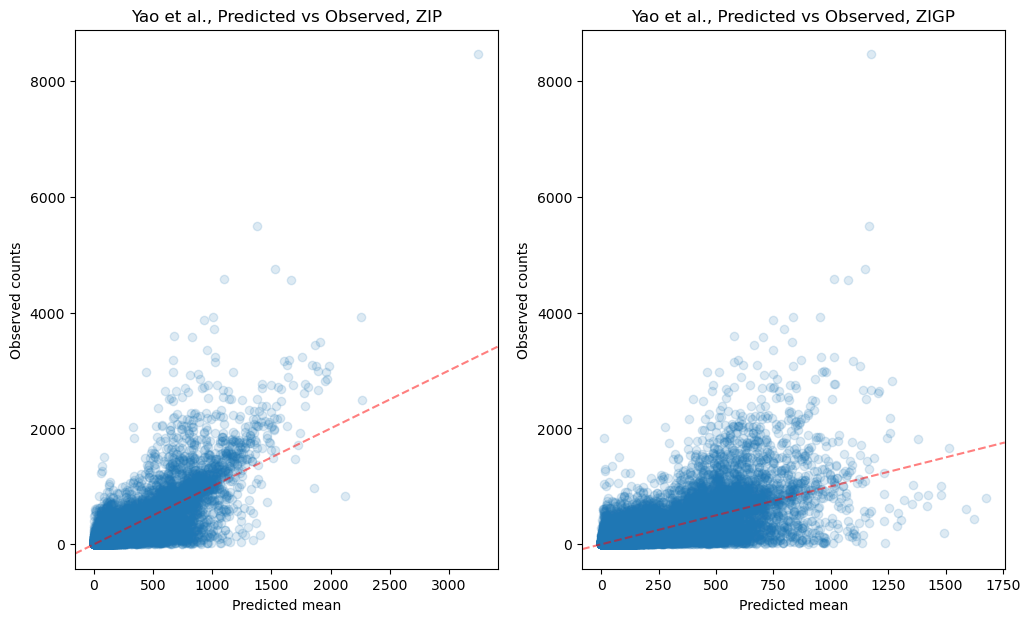

In [15]:
# compute prediction over test set
# unique_pert = test_conditioner
# avg_pred = np.zeros((len(unique_pert), adata.X.shape[1]))
# avg_obs = np.zeros((len(unique_pert), adata.X.shape[1]))
# for i, pert in enumerate(list(unique_pert)):
#     if i%10 == 0:
#         print(i)
#     my_id = [i]
#     predicted_mu_mean, predicted_mu_var, predicted_base_mean, logit_p, logit_p_log_var = parametric_model(my_conditioner[parametric_model.test_id][my_id], my_cell_info[parametric_model.test_id][my_id])
#     estimated_base_mean = predicted_base_mean  # * zeros[testing_idx].numpy()
#     estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean)
#     avg_pred[i] = logexpp1(estimated_perturbed_mean + estimated_base_mean).detach().cpu().numpy().mean(0)
#     avg_obs[i] = my_observation[parametric_model.test_id][my_id].mean(0).cpu().numpy()

# load from precomputed


fig, axes = plt.subplots(1, 2)
np.random.seed(314159)
avg_pred = np.loadtxt('./GPerturb_vis_data/yao_avg_pred_GPerturb_zip.csv').ravel()
avg_obs = np.loadtxt('./GPerturb_vis_data/yao_avg_obs_GPerturb_zip.csv').ravel()
avg_pred = avg_pred[avg_obs != 0]
avg_obs = avg_obs[avg_obs != 0]
axes[0].scatter(avg_pred, avg_obs, alpha=0.15)
axes[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0].set_xlabel('Predicted mean')
axes[0].set_ylabel('Observed counts')
axes[0].set_title('Yao et al., Predicted vs Observed, ZIP')

avg_pred = np.loadtxt('./GPerturb_vis_data/yao_avg_pred_GPerturb_zinb.csv').ravel()
avg_obs = np.loadtxt('./GPerturb_vis_data/yao_avg_obs_GPerturb_zinb.csv').ravel()
avg_pred = avg_pred[avg_obs != 0]
avg_obs = avg_obs[avg_obs != 0]
axes[1].scatter(avg_pred, avg_obs, alpha=0.15)
axes[1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1].set_xlabel('Predicted mean')
axes[1].set_ylabel('Observed counts')
axes[1].set_title('Yao et al., Predicted vs Observed, ZIGP')

fig.set_size_inches(12, 7)
plt.savefig('yao_count.png')

# Histogram of log dispersion parameters from four datasets 

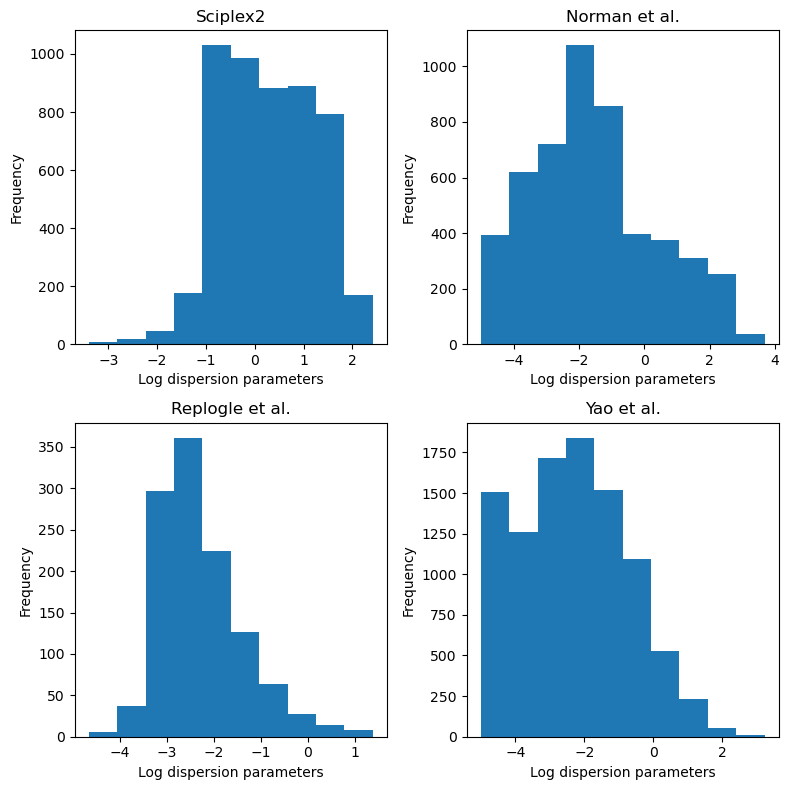

In [12]:

# dispersion
fig, axes = plt.subplots(2, 2)
lst = ['Sciplex2_zinb_dispersion.csv', 'rep_zinb_dispersion.csv', 'Norman_zinb_dispersion.csv','yao_zinb_dispersion.csv']
name = ['Sciplex2', 'Replogle et al.', 'Norman et al.', 'Yao et al.']
for i in range(4):
    dispersion = pd.read_csv('./GPerturb_vis_data/'+lst[i]).to_numpy().ravel()
    # less than 5% of genes > 0
    axes[i%2, i//2].hist(dispersion[dispersion>-5])  # truncated for readability
    axes[i%2, i//2].set_xlabel('Log dispersion parameters')
    axes[i%2, i//2].set_ylabel('Frequency')
    axes[i%2, i//2].set_title('{}'.format(name[i]))
fig.set_size_inches(8, 8)
fig.tight_layout()
# plt.savefig('dispersion.png')
# plt.close()